In [1]:
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime


C:\Users\Ian\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def display_all(df):
    """
    display all the rows and columns up to 1000
    """
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

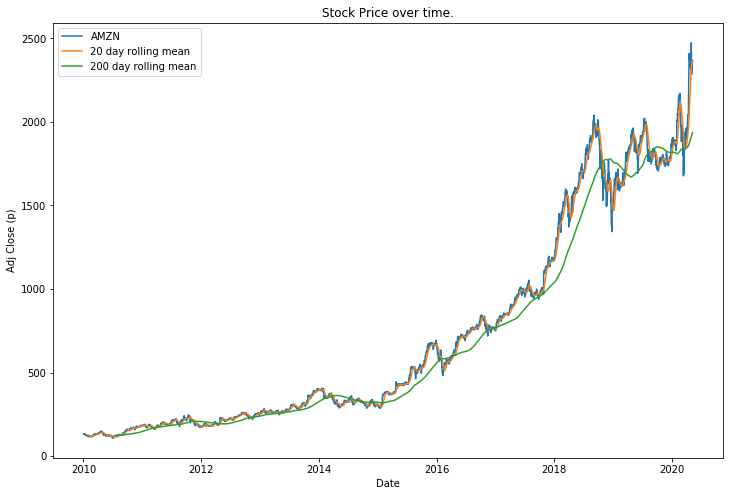

In [3]:
start_date = '2010-01-01'
end_date = str(datetime.now().strftime('%Y-%m-%d'))


ticker = 'AMZN'

def get_stats(stock_data):
    return {
        'last': np.mean(stock_data.tail(1)),
        'short_mean':np.mean(stock_data.tail(20)),
        'long_mean':np.mean(stock_data.tail(200)),
        'short_rolling': stock_data.rolling(window=20).mean(),
        'long_rolling': stock_data.rolling(window=200).mean()
    }

def create_plt(stock_data, ticker):
    stats = get_stats(stock_data)
    plt.subplots(figsize=(12,8))
    plt.plot(stock_data, label=ticker)
    plt.plot(stats['short_rolling'], label='20 day rolling mean')
    plt.plot(stats['long_rolling'], label='200 day rolling mean')
    plt.xlabel('Date')
    plt.ylabel('Adj Close (p)')
    plt.legend()
    plt.title('Stock Price over time.')
    plt.show()


def clean_data(stock_data, col):
    weekdays = pd.date_range(start=start_date, end=end_date)
    clean_data = stock_data[col].reindex(weekdays)
    return clean_data.fillna(method='ffill')


def get_data(ticker):
    try:
        stock_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
        adj_close = clean_data(stock_data, 'Adj Close')
        create_plt(adj_close, ticker)
    except RemoteDataError:
        print('No data found for {t}'.format(t=ticker))
        
get_data(ticker)

In [4]:
import yfinance as yf

msft = yf.Ticker("MSFT")

# # get stock info
# msft.info

# # get historical market data
# hist = msft.history(period="max")

# #show actions (dividends, splits)
# msft.actions

# # show dividends
# msft.dividends

# # show splits
# msft.splits

# # show financials
# msft.financials
# msft.quarterly_financials

# # show major holders
# stock.major_holders

# # show institutional holders
# stock.institutional_holders

# # show balance heet
# msft.balance_sheet
# msft.quarterly_balance_sheet

# # show cashflow
# msft.cashflow
# msft.quarterly_cashflow

# # show earnings
# msft.earnings
# msft.quarterly_earnings

# # show sustainability
# msft.sustainability

# # show analysts recommendations
# msft.recommendations

# # show next event (earnings, etc)
# msft.calendar

# # show ISIN code - *experimental*
# # ISIN = International Securities Identification Number
# msft.isin

# # show options expirations
# msft.options

# # get option chain for specific expiration
# opt = msft.option_chain('YYYY-MM-DD')
# # data available via: opt.calls, opt.puts

In [5]:
prime_standard = pd.read_excel('GermanCompany.xlsx', sheet_name='Prime Standard')
general_standard = pd.read_excel('GermanCompany.xlsx', sheet_name='General Standard')
scale = pd.read_excel('GermanCompany.xlsx', sheet_name='Scale')

In [6]:
def remove_unnamed_col(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df
prime_standard = remove_unnamed_col(prime_standard)
general_standard = remove_unnamed_col(general_standard)
scale = remove_unnamed_col(scale)

In [7]:
df = pd.concat([prime_standard, general_standard, scale], axis=0)
def rm_white_space(df):
    for col in df.columns:
        df[col] = df[col].str.strip()
rm_white_space(df)
df = df.reset_index(drop=True)

In [8]:
df.loc[0]

ISIN                             DE0005545503
Trading Symbol                            DRI
Company                 1+1 DRILLISCH AG O.N.
Sector                      Telecommunication
Subsector              Wireless Communication
Country                               Germany
Instrument Exchange         XETRA + FRANKFURT
Name: 0, dtype: object

In [9]:
############ Getting the big four numbers
#'1+1 DRILLISCH AG O.N. some wireless communication company'
com = yf.Ticker(df.loc[0,'Trading Symbol'])
incomeStatement = com.financials
# Net Income
netIncome = incomeStatement.loc[incomeStatement.index=='Net Income']
# Sales
sales = incomeStatement.loc[incomeStatement.index=='Total Revenue']

In [10]:
## Book Value
balanceSheet = com.balance_sheet
totalAssetsLiability= balanceSheet.loc[balanceSheet.index.isin(['Total Liab','Total Assets'])]
totalAssetsLiability.loc['bookValue'] = totalAssetsLiability.loc['Total Assets'] - totalAssetsLiability.loc['Total Liab']
totalAssetsLiability

C:\Users\Ian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,2019-05-26,2018-05-27,2017-05-28,2016-05-29
Total Liab,3.500200e+09,3.274800e+09,3.190600e+09,2.630600e+09
Total Assets,5.892800e+09,5.469600e+09,5.292300e+09,4.582600e+09
bookValue,2.392600e+09,2.194800e+09,2.101700e+09,1.952000e+09


In [11]:
## Operating Cash
cashFlow = com.cashflow
operatingCash = cashFlow.loc[cashFlow.index == 'Total Cash From Operating Activities']
operatingCash

,2019-05-26,2018-05-27,2017-05-28,2016-05-29
Total Cash From Operating Activities,1.257200e+09,1.001300e+09,898000000.0,778000000.0


In [12]:
#operatingCash['metric'] = operatingCash.index
#operatingCash.reset_index()

In [13]:
# operatingCash.index = operatingCash.index.set_names(['metric'])
# operatingCash = operatingCash.reset_index().rename(columns={operatingCash.index.name:'metric'})

In [14]:
df = pd.concat([netIncome, sales,totalAssetsLiability, operatingCash])
df.sort_index(axis=1, inplace = True)

df.index

Index(['Net Income', 'Total Revenue', 'Total Liab', 'Total Assets',
       'bookValue', 'Total Cash From Operating Activities'],
      dtype='object')

In [15]:
df

,2016-05-29,2017-05-28,2018-05-27,2019-05-26
Net Income,3.75e+08,4.791e+08,5.96e+08,7.134e+08
Total Revenue,6.9335e+09,7.1702e+09,8.0801e+09,8.5104e+09
Total Liab,2.6306e+09,3.1906e+09,3.2748e+09,3.5002e+09
Total Assets,4.5826e+09,5.2923e+09,5.4696e+09,5.8928e+09
bookValue,1.952e+09,2.1017e+09,2.1948e+09,2.3926e+09
Total Cash From Operating Activities,7.78e+08,8.98e+08,1.0013e+09,1.2572e+09


In [16]:
chg = df.pct_change(axis=1)
chg = chg.set_index(chg.index.astype(str)+'_pct')
chg

,2016-05-29,2017-05-28,2018-05-27,2019-05-26
Net Income_pct,NaN,0.277600,0.243999,0.196980
Total Revenue_pct,NaN,0.034139,0.126900,0.053254
Total Liab_pct,NaN,0.212879,0.026390,0.068829
Total Assets_pct,NaN,0.154868,0.033502,0.077373
bookValue_pct,NaN,0.076691,0.044297,0.090122
Total Cash From Operating Activities_pct,NaN,0.154242,0.115033,0.255568


In [17]:
com.quarterly_balance_sheet

,2020-02-23,2019-11-24,2019-08-25,2019-05-26
Intangible Assets,9.508000e+08,9.508000e+08,9.508000e+08,1.075400e+09
Total Liab,7.632100e+09,7.469000e+09,7.338200e+09,3.500200e+09
Total Stockholder Equity,2.341200e+09,2.273700e+09,2.381300e+09,2.392600e+09
Other Current Liab,9.488000e+08,8.605000e+08,8.524000e+08,5.039000e+08
Total Assets,9.973300e+09,9.742700e+09,9.719500e+09,5.892800e+09
Common Stock,1.693000e+09,1.690000e+09,1.692900e+09,1.685000e+09
Other Current Assets,2.010000e+07,4.470000e+07,5.800000e+06,4.160000e+07
Retained Earnings,6.486000e+08,5.845000e+08,7.899000e+08,8.066000e+08
Other Liab,3.590000e+08,3.563000e+08,3.334000e+08,9.299000e+08
Good Will,1.205500e+09,1.199400e+09,1.199700e+09,1.183700e+09


In [18]:
#d.options.display.float_format = ‘{:.2f}%’.format

### Income Statement

In [19]:
import requests

In [20]:
####################################################################################
############# Income Statement compare across companies ############################
####################################################################################

def latestIncomeStatement(quote):
    r = requests.get(f"https://financialmodelingprep.com/api/v3/financials/income-statement/{quote}")
    r = r.json()
    incomeStatement = r['financials']
    incomeStatement = pd.DataFrame.from_dict(incomeStatement)
    incomeStatement = incomeStatement.T
    incomeStatement.columns = incomeStatement.iloc[0]
    incomeStatement.reset_index(inplace=True)
    incomeStatement = incomeStatement.iloc[:,0:2]
    incomeStatement = incomeStatement.rename(columns={incomeStatement.columns[1]:quote})

    cols = incomeStatement.columns.drop('index')
    incomeStatement[cols] = incomeStatement[cols].apply(pd.to_numeric, errors='coerce')
    incomeStatement = incomeStatement.iloc[1:,:]
    incomeStatement[quote] = incomeStatement[quote]/incomeStatement.iloc[0,1]
    incomeStatement[quote] = pd.Series(["{0:.2f}%".format(val*100) for val in incomeStatement[quote]],index=incomeStatement.index)
    return incomeStatement



df = latestIncomeStatement('FB')

listofstocks = ['AAPL','MSFT','GOOGL']

for i in listofstocks:
    y = latestIncomeStatement(i)
    df = df.merge(y, on='index')

df

date,index,FB,AAPL,MSFT,GOOGL
0,Revenue,100.00%,100.00%,100.00%,100.00%
1,Revenue Growth,0.00%,-0.00%,0.00%,0.00%
2,Cost of Revenue,18.06%,62.18%,34.10%,44.42%
3,Gross Profit,81.94%,37.82%,65.90%,55.58%
4,R&D Expenses,19.24%,6.23%,13.41%,16.07%
5,SG&A Expense,28.77%,7.01%,18.35%,17.31%
6,Operating Expenses,61.16%,13.25%,31.76%,33.38%
7,Operating Income,33.93%,24.57%,34.14%,21.15%
8,Interest Expense,0.03%,1.37%,2.13%,0.06%
9,Earnings before Tax,35.10%,25.27%,12.55%,24.48%


In [21]:
####################################################################################
############# Income Statement History for one company #############################
####################################################################################


def incomeStatementHistorical(quote):
    r = requests.get(f"https://financialmodelingprep.com/api/v3/financials/income-statement/{quote}")
    r = r.json()
    incomeStatement = r['financials']
    incomeStatement = pd.DataFrame.from_dict(incomeStatement)
    incomeStatement = incomeStatement.T
    incomeStatement.columns = incomeStatement.iloc[0]
    incomeStatement.reset_index(inplace=True)
    incomeStatement = incomeStatement.iloc[1:,0:]
    #incomeStatement = incomeStatement.rename(columns={incomeStatement.columns[1]:quote})

    cols = incomeStatement.columns.drop('index')
    incomeStatement[cols] = incomeStatement[cols].apply(pd.to_numeric, errors='coerce')

    ####################################
    # Original Copy of Income Statement#
    ####################################
    ori_incomeStatement = incomeStatement.copy()


    ####################
    # percentage change#
    ####################
    incomeStatement[cols] = incomeStatement[cols].pct_change(-1, axis=1)
    incomeStatement[cols] = incomeStatement[cols].multiply(100)
    for col in cols:
        incomeStatement[col] = round(incomeStatement[col],2).astype(str) + '%'
    incomeStatement['index'] = incomeStatement['index'].apply(lambda x: "{}{}".format(x,' chg_prev'))
    chg_incomeStatement = incomeStatement.copy()
    
    ####################
    ## Combining both ##
    ####################
    df = pd.concat([ori_incomeStatement, chg_incomeStatement])
    df.sort_index(inplace=True)
    
    # Dropping columns not needed for now
    to_drop = ['Revenue Growth','Revenue Growth chg_prev','Net Income - Non-Controlling int chg_prev','Net Income - Non-Controlling int','Net Income - Discontinued ops','Net Income - Discontinued ops chg_prev','Weighted Average Shs Out chg_prev']
    df = df[~df['index'].isin(to_drop)]
    df.sort_values('index')
    df.reset_index(drop=True, inplace=True)
    
    return df

incomeStatementHistorical('GOOGL')


date,index,2019-12-31,2018-12-31,2017-12-31,2016-12-31,2015-12-31,2014-12-31,2013-12-31,2012-12-31,2011-12-31,2010-12-31,2009-12-31
0,Revenue,1.61857e+11,1.36819e+11,1.10855e+11,9.0272e+10,7.4989e+10,6.6001e+10,5.5519e+10,4.6039e+10,3.7905e+10,2.9321e+10,2.3651e+10
1,Revenue chg_prev,18.3%,23.42%,22.8%,20.38%,13.62%,18.88%,20.59%,21.46%,29.28%,23.97%,nan%
2,Cost of Revenue,7.1896e+10,5.9549e+10,4.5583e+10,3.5138e+10,2.8164e+10,2.5691e+10,2.1993e+10,1.7176e+10,1.3188e+10,1.0417e+10,8.844e+09
3,Cost of Revenue chg_prev,20.73%,30.64%,29.73%,24.76%,9.63%,16.81%,28.04%,30.24%,26.6%,17.79%,nan%
4,Gross Profit,8.9961e+10,7.727e+10,6.5272e+10,5.5134e+10,4.6825e+10,4.031e+10,3.3526e+10,2.8863e+10,2.4717e+10,1.8904e+10,1.4807e+10
5,Gross Profit chg_prev,16.42%,18.38%,18.39%,17.74%,16.16%,20.24%,16.16%,16.77%,30.75%,27.67%,nan%
6,R&D Expenses,2.6018e+10,2.1419e+10,1.6625e+10,1.3948e+10,1.2282e+10,9.832e+09,7.137e+09,6.083e+09,5.162e+09,3.762e+09,2.843e+09
7,R&D Expenses chg_prev,21.47%,28.84%,19.19%,13.56%,24.92%,37.76%,17.33%,17.84%,37.21%,32.33%,nan%
8,SG&A Expense chg_prev,14.54%,23.75%,13.14%,15.06%,8.59%,27.27%,22.8%,22.33%,53.6%,30.37%,nan%
9,SG&A Expense,2.8015e+10,2.4459e+10,1.9765e+10,1.747e+10,1.5183e+10,1.3982e+10,1.0986e+10,8.946e+09,7.313e+09,4.761e+09,3.652e+09


## Balance Sheet

In [23]:
def balanceSheetHistorical(quote):

    r = requests.get(f"https://financialmodelingprep.com/api/v3/financials/balance-sheet-statement/{quote}")
    r = r.json()
    balanceSheet = r['financials']
    balanceSheet = pd.DataFrame.from_dict(balanceSheet)
    balanceSheet['Book Value'] = balanceSheet['Total assets'].astype('float32') - balanceSheet['Total liabilities'].astype('float32')
    balanceSheet = balanceSheet.T
    balanceSheet.columns = balanceSheet.iloc[0]
    balanceSheet = balanceSheet.iloc[1:,:]
    balanceSheet.reset_index(inplace=True)


    ####################################
    ### Original Copy of Balance Sheet##
    ####################################
    ori_balanceSheet = balanceSheet.copy()


    ####################
    # percentage change#
    ####################
    cols = ori_balanceSheet.columns.drop('index')
    balanceSheet[cols] = balanceSheet[cols].apply(pd.to_numeric, errors='coerce')
    balanceSheet[cols] = balanceSheet[cols].pct_change(-1, axis=1)
    balanceSheet[cols] = balanceSheet[cols].multiply(100)
    for col in cols:
        balanceSheet[col] = round(balanceSheet[col],2).astype(str) + '%'
    balanceSheet['index'] = balanceSheet['index'].apply(lambda x: "{}{}".format(x,'_chg_prev'))
    chg_balanceSheet = balanceSheet.copy()

    df = pd.concat([ori_balanceSheet, chg_balanceSheet])
    df.sort_index(inplace=True)
    df.reset_index(inplace=True, drop= True)
    return df

df = balanceSheetHistorical('AAPL')
df.sort_values('index')

date,index,2019-09-28,2018-09-29,2017-09-30,2016-09-24,2015-09-26,2014-09-27,2013-09-28,2012-09-29,2011-09-24,2010-09-25,2009-09-26
58,Book Value,9.0488e+10,1.07147e+11,1.34047e+11,1.28249e+11,1.19355e+11,1.11547e+11,1.23549e+11,1.1821e+11,7.6615e+10,4.7791e+10,3.164e+10
59,Book Value_chg_prev,-15.55%,-20.07%,4.52%,7.45%,7.0%,-9.71%,4.52%,54.29%,60.31%,51.05%,nan%
0,Cash and cash equivalents,48844000000.0,25913000000.0,20289000000.0,20484000000.0,21120000000.0,13844000000.0,14259000000.0,10746000000.0,9815000000.0,11261000000.0,5263000000.0
1,Cash and cash equivalents_chg_prev,88.49%,27.72%,-0.95%,-3.01%,52.56%,-2.91%,32.69%,9.49%,-12.84%,113.97%,nan%
4,Cash and short-term investments,1.00557e+11,66301000000.0,74181000000.0,67155000000.0,41601000000.0,25077000000.0,40546000000.0,29129000000.0,25952000000.0,25620000000.0,23464000000.0
5,Cash and short-term investments_chg_prev,51.67%,-10.62%,10.46%,61.43%,65.89%,-38.15%,39.19%,12.24%,1.3%,9.19%,nan%
35,Deferred revenue,5522000000.0,7543000000.0,7548000000.0,8080000000.0,8940000000.0,8491000000.0,7435000000.0,5953000000.0,4091000000.0,2984000000.0,2906000000.0
34,Deferred revenue_chg_prev,-26.79%,-0.07%,-6.58%,-9.62%,5.29%,14.2%,24.9%,45.51%,37.1%,2.68%,nan%
39,Deposit Liabilities,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,Deposit Liabilities_chg_prev,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%


In [136]:
def warrenBigFour(quote):
    
    """
    Operating Income:Operating income, often referred to as EBIT or earnings before interest and taxes, is a profitability formula that calculates a company’s profits derived from operations. In other words, it measures the amount of money a company makes from its core business activities not including other income expenses not directly related to the core activities of the business.
    Operating Income formula: Gross income - Operating expenses - Depreciation & Amortization
    
    Book Value: Book value is the total value of a business' assets found on its balance sheet, and represents the value of all assets if liquidated.
    Book Value formula = total assets - total liabilities
    
    Net income: The net income formula is calculated by subtracting total expenses from total revenues
    Net income: Total revnenues - total expenses    
    """
    
    # Getting data from income statement
    df = incomeStatementHistorical(quote)
    keyMetric = ['Net Income','Net Income chg_prev','Revenue','Revenue chg_prev','Operating Income','Operating Income chg_prev']
    df_metric1 = df.loc[df['index'].isin(keyMetric)]
    
    # getting data from balance sheet
    df = balanceSheetHistorical(quote)
    keyMetric = ['Book Value','Book Value_chg_prev']
    df_metric2 = df.loc[df['index'].isin(keyMetric)]
    test = pd.concat([df_metric1, df_metric2])
    test = test.sort_values('index')
    test.reset_index(inplace=True, drop=True)
    return test

df = warrenBigFour('GOOGL')
df

date,index,2019-12-31,2018-12-31,2017-12-31,2016-12-31,2015-12-31,2014-12-31,2013-12-31,2012-12-31,2011-12-31,2010-12-31,2009-12-31
0,Book Value,2.01442e+11,1.77628e+11,1.52502e+11,1.39036e+11,1.20331e+11,1.0386e+11,8.7309e+10,7.1715e+10,5.8145e+10,4.6241e+10,3.6004e+10
1,Book Value_chg_prev,13.41%,16.48%,9.69%,15.54%,15.86%,18.96%,21.74%,23.34%,25.74%,28.43%,nan%
2,Net Income,3.4343e+10,3.0736e+10,1.2662e+10,1.9478e+10,1.6348e+10,1.4136e+10,1.2733e+10,1.0737e+10,9.737e+09,8.505e+09,6.52e+09
3,Net Income chg_prev,11.74%,142.74%,-34.99%,19.15%,15.65%,11.02%,18.59%,10.27%,14.49%,30.44%,nan%
4,Operating Income,3.4231e+10,2.6321e+10,2.6146e+10,2.3716e+10,1.936e+10,1.6496e+10,1.5403e+10,1.3834e+10,1.1742e+10,1.0381e+10,8.312e+09
5,Operating Income chg_prev,30.05%,0.67%,10.25%,22.5%,17.36%,7.1%,11.34%,17.82%,13.11%,24.89%,nan%
6,Revenue,1.61857e+11,1.36819e+11,1.10855e+11,9.0272e+10,7.4989e+10,6.6001e+10,5.5519e+10,4.6039e+10,3.7905e+10,2.9321e+10,2.3651e+10
7,Revenue chg_prev,18.3%,23.42%,22.8%,20.38%,13.62%,18.88%,20.59%,21.46%,29.28%,23.97%,nan%


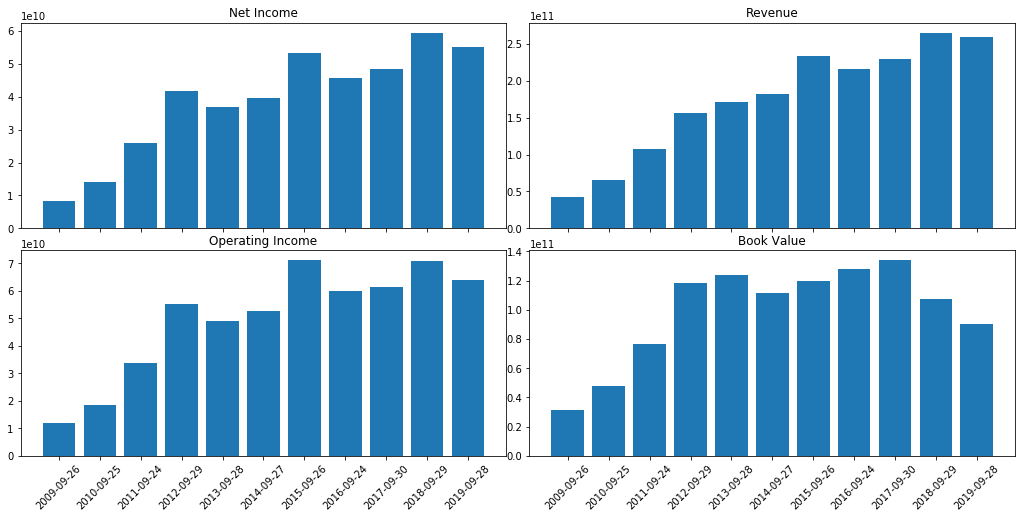

In [128]:
#### far from ready

import matplotlib.pyplot as plt
metric = ['Net Income','Revenue','Operating Income','Book Value']
fig, ax = plt.subplots(2,2, figsize = [14,7], sharex=True)
counter = 0
for a in range(2):
    for b in range(2):
        
        df_temp = df.loc[df['index'] == metric[counter]].copy()
        cols = df_temp.columns.drop('index')
        df_temp[cols] = df_temp[cols].apply(pd.to_numeric, errors='coerce')
        df_temp = df_temp.T[1:]
        df_temp = df_temp.rename(columns={df_temp.columns[0]:'metric'})
        df_temp = df_temp.sort_values('date')    
        ax[a,b].bar(df_temp.index, df_temp['metric'])
        ax[a,b].set_title(metric[counter])
        ax[a,b].set_xticklabels(df_temp.index, rotation=45)
        counter +=1
plt.tight_layout(pad=0)   

## Financial Ratios

In [30]:
def financialratios(quote):
    r = requests.get(f"https://financialmodelingprep.com/api/v3/financial-ratios/{quote}")
    r = r.json()
    valuation = r['ratios'][0]['investmentValuationRatios']
    profitability = r['ratios'][0]['profitabilityIndicatorRatios']
    operating = r['ratios'][0]['operatingPerformanceRatios']
    liquidity = r['ratios'][0]['liquidityMeasurementRatios']
    debt = r['ratios'][0]['debtRatios']

    valuation = pd.DataFrame(list(valuation.items()),columns=['Ratio',quote])
    profitability = pd.DataFrame(list(profitability.items()),columns=['Ratio',quote])
    operating = pd.DataFrame(list(operating.items()),columns=['Ratio',quote])
    liquidity = pd.DataFrame(list(liquidity.items()),columns=['Ratio',quote])
    debt = pd.DataFrame(list(debt.items()),columns=['Ratio',quote])

    final_df = pd.concat([valuation, profitability, operating, liquidity, debt])
    return final_df


listofstocks = ['AAPL','MSFT','TSLA']
x = financialratios('FB')

for i in listofstocks:
    y = financialratios(i)
    x = x.merge(y, on='Ratio')
    
display_all(x.drop_duplicates())

,Ratio,FB,AAPL,MSFT,TSLA
0,priceBookValueRatio,5.9176145427197335,12.709658271815046,10.52384979966774,17.13861740707162
1,priceToBookRatio,5.9176145427197335,12.709658271815046,10.52384979966774,17.13861740707162
2,priceToSalesRatio,8.45861380256588,4.420393881402446,8.557532401484389,4.614833184148425
3,priceEarningsRatio,32.35047984852583,20.81351450883162,27.444076197757386,-131.58163573085847
4,receivablesTurnover,7.427715906703089,11.34842536857716,4.262396694214876,18.563444108761328
20,priceToFreeCashFlowsRatio,28.19152460871205,19.527159020986144,28.147034762153684,105.70677539608573
21,priceToOperatingCashFlowsRatio,16.46744010574434,16.573785616290298,20.636304493628437,47.1614844074844
22,priceCashFlowRatio,16.46744010574434,16.573785616290298,20.636304493628437,47.1614844074844
23,priceEarningsToGrowthRatio,4.175482520246596,1.6145093305735827,12.707645686162117,23.860428509597924
24,priceSalesRatio,8.45861380256588,4.420393881402446,8.557532401484389,4.614833184148425


In [33]:
keyRatios = ['grossProfitMargin','operatingProfitMargin','pretaxProfitMargin','netProfitMargin']
"""
Definitions
Gross Profit Margin: You can think of it as the amount of money from product sales left over after all of the direct costs associated 
        with manufacturing the product have been paid. Gross profit is calculated by subtracting Cost Of Goods Sold (All the 
        variable costs including direct labour, materials, packaging, and others) from Revenue.
Operating Profit Margin: The operating profit margin shows the percentage of profit made before deducting taxes and interest 
        charges. Operating profit or income is calculated by subtracting all COGS, amortization, depreciation, and operating expenses 
        from revenue. Many argue that the operating profit margin is the best ratio for determining management effectiveness, because 
        it shows all the costs which they can control are represented. 
Pretax Profit Margin:  pretax profit margin shows us how profitable a firm is before taxes are deducted. This is often a better 
        measure than net profit margin because tax rates vary considerably between cities, states, and nations, and this is usually out 
        of the control of management.
Net profit margin is the mother of all profitability ratios and the one most commonly used by analysts. It looks at the 
        percentage of net income to revenue. Net income is calculated by subtracting all expenses (COGS, operating expenses, taxes, 
        interest expense, and other expenses) from revenue. Whereas gross profit margin is good at seeing efficiency of production of 
        goods/service delivery, net profit margin gives a greater insight into how the whole company is being run. 
"""

x.loc[x['Ratio'].isin(keyRatios)]

,Ratio,FB,AAPL,MSFT,TSLA
31,grossProfitMargin,0.8193699874110641,0.3781776810903472,0.6590195720063889,0.1655545609895028
32,operatingProfitMargin,0.3392788944368219,0.24572017188496928,0.3413698020549415,-0.002807388721620962
33,pretaxProfitMargin,0.350962558524407,0.2526655238417367,0.12554532234609792,-0.027056717389535356
34,netProfitMargin,0.2614679547929898,0.21238094505984456,0.3118171054409065,-0.03507201562372854
